In [40]:
import numpy as np
import pandas as pd
import requests
import random
from io import BytesIO
import pickle
from collections import OrderedDict
import os
from os import path
import time
import argparse
import wget
import ast
import json
from PIL import Image, ImageDraw, ImageOps
import ndjson
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import image_utils
from image_utils import add_flipped_and_rotated_images

# import pytorch
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader

# import machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [41]:
categories = ['apple', 'clock', 'door', 'diamond', 'fork', 'eye', 'star', 'axe', 'sword', 'fish']
data_filepath = '../datasets'
num_categories = len(categories)
num_examples = 1000
label_dict = {}
width = 256
height = 256

In [42]:
for i in range(0,num_categories):
    label_dict[i] = categories[i]

Save label dictionary

In [43]:
with open('../service/label_dict.json', 'w') as f:
    json.dump(categories, f)

### Download datasets

Google quickdraw dataset (<a href='https://github.com/googlecreativelab/quickdraw-dataset#the-raw-moderated-dataset'>More</a>)

In [44]:
# URL to dataset in GCP Storage
dataset_url = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'

In [45]:
for category in categories:
    if not os.path.exists(data_filepath + '/' + str(category) + '.npy'):
        print("Start downloading data process for [{}].".format(category))
        url = dataset_url + str(category) + '.npy'
        wget.download(
                    url=url,
                    out=data_filepath
                )
        print("Dataset for {} was successfully downloaded.".format(category))
    else:
        print("Dataset for {} is already downloaded.".format(category))

Dataset for apple is already downloaded.
Dataset for clock is already downloaded.
Dataset for door is already downloaded.
Dataset for diamond is already downloaded.
Dataset for fork is already downloaded.
Dataset for eye is already downloaded.
Dataset for star is already downloaded.
Dataset for axe is already downloaded.
Dataset for sword is already downloaded.
Dataset for fish is already downloaded.


### Prepare datasets

In [46]:
classes_dict = {}
for category in categories:
    classes_dict[category] = np.load(data_filepath + '/' + str(category) + '.npy')

In [47]:
# Generate labels and add labels to loaded data
for i, (key, value) in enumerate(classes_dict.items()):
    value = value.astype('float32')/255.
    if i == 0:
        classes_dict[key] = np.c_[value, np.zeros(len(value))]
    else:
        classes_dict[key] = np.c_[value,i*np.ones(len(value))]

lst = []
for key, value in classes_dict.items():
    lst.append(value[:3000])
tmp = np.concatenate(lst)

# Split the data into features and class labels (X & y respectively)
y = tmp[:,-1].astype('float32')
X = tmp[:,:784]

# Split each dataset into train/test splits
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=1)

In [48]:
def view_images_grid(X, y):
    fig, axs = plt.subplots(5, 10, figsize=(20,10))
    
    for label_num in range(0,50):
        r_label = random.randint(0, len(X) - 1)
        image = X[r_label].reshape(28,28)  #reshape images
        i = label_num // 10
        j = label_num % 10
        axs[i,j].imshow(image) #plot the data
        axs[i,j].axis('off')
        axs[i,j].set_title(label_dict[y[r_label]])

    plt.show()

In [49]:
X_train, y_train = image_utils.add_flipped_and_rotated_images(X_train, y_train)

Adding flipped and rotated images to the training set. 

Processed 0 files out of 21000.
Processed 100 files out of 21000.
Processed 200 files out of 21000.
Processed 300 files out of 21000.
Processed 400 files out of 21000.
Processed 500 files out of 21000.
Processed 600 files out of 21000.
Processed 700 files out of 21000.
Processed 800 files out of 21000.
Processed 900 files out of 21000.
Processed 1000 files out of 21000.
Processed 1100 files out of 21000.
Processed 1200 files out of 21000.
Processed 1300 files out of 21000.
Processed 1400 files out of 21000.
Processed 1500 files out of 21000.
Processed 1600 files out of 21000.
Processed 1700 files out of 21000.
Processed 1800 files out of 21000.
Processed 1900 files out of 21000.
Processed 2000 files out of 21000.
Processed 2100 files out of 21000.
Processed 2200 files out of 21000.
Processed 2300 files out of 21000.
Processed 2400 files out of 21000.
Processed 2500 files out of 21000.
Processed 2600 files out of 21000.
Processed 

KeyboardInterrupt: 

In [ ]:
view_images_grid(X_train, y_train)

In [ ]:
X_tensor_train = torch.from_numpy(X_train).float()
y_tensor_train = torch.from_numpy(y_train).long()
X_tensor_test = torch.from_numpy(X_test).float()
y_tensor_test = torch.from_numpy(y_test).long()

### Describe model

In [12]:
# Hyperparameters for our network
input_size = 784
hidden_sizes = [128, 100, 64]
output_size = 10
dropout = 0.0

In [13]:
def build_model(input_size = 784, output_size = 10, hidden_sizes = [128, 100, 64]):
    return nn.Sequential(OrderedDict([
                            ('fc1', nn.Linear(input_size, hidden_sizes[0])),
                            ('relu1', nn.ReLU()),
                            ('fc2', nn.Linear(hidden_sizes[0], hidden_sizes[1])),
                            ('bn2', nn.BatchNorm1d(num_features = hidden_sizes[1])),
                            ('relu2', nn.ReLU()),
                            ('dropout', nn.Dropout(dropout)),
                            ('fc3', nn.Linear(hidden_sizes[1], hidden_sizes[2])),
                            ('bn3', nn.BatchNorm1d(num_features = hidden_sizes[2])),
                            ('relu3', nn.ReLU()),
                            ('logits', nn.Linear(hidden_sizes[2], output_size))]))

### Train model

In [14]:
train = X_tensor_train
train_labels = y_tensor_train
test = X_tensor_test
test_labels = y_tensor_test

In [15]:
def shuffle(X_train, y_train):
    X_train_shuffled = X_train.numpy()
    y_train_shuffled = y_train.numpy().reshape((X_train.shape[0], 1))

    permutation = list(np.random.permutation(X_train.shape[0]))
    X_train_shuffled = X_train_shuffled[permutation, :]
    y_train_shuffled = y_train_shuffled[permutation, :].reshape((X_train.shape[0], 1))

    X_train_shuffled = torch.from_numpy(X_train_shuffled).float()
    y_train_shuffled = torch.from_numpy(y_train_shuffled).long()

    return X_train_shuffled, y_train_shuffled

In [16]:
def fit_model(model, X_train, y_train, epochs = 100, n_chunks = 1000, learning_rate = 0.003, weight_decay = 0):
    print("Fitting model with epochs = {epochs}, learning rate = {lr}"\
    .format(epochs = epochs, lr = learning_rate))

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay= weight_decay)

    print_every = 100
    steps = 0

    for e in range(epochs):
        running_loss = 0

        X_train, y_train = shuffle(X_train, y_train)

        images = torch.chunk(X_train, n_chunks)
        labels = torch.chunk(y_train, n_chunks)

        for i in range(n_chunks):
            steps += 1

            optimizer.zero_grad()

            # Forward and backward passes
            output = model.forward(images[i])
            loss = criterion(output, labels[i].squeeze())
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if steps % print_every == 0:
                print("Epoch: {}/{} ".format(e+1, epochs),
                      "Loss: {:.4f}".format(running_loss/print_every))

                running_loss = 0

In [17]:
def get_preds(model, input):
    with torch.no_grad():
        logits = model.forward(input)

    ps = F.softmax(logits, dim=1)
    return ps

In [18]:
def get_labels(pred):
    pred_np = pred.numpy()
    pred_values = np.amax(pred_np, axis=1, keepdims=True)
    pred_labels = np.array([np.where(pred_np[i, :] == pred_values[i, :])[0] for i in range(pred_np.shape[0])])
    pred_labels = pred_labels.reshape(len(pred_np), 1)

    return pred_labels

In [19]:
def evaluate_model(model, train, y_train, test, y_test):
    train_pred = get_preds(model, train)
    train_pred_labels = get_labels(train_pred)

    test_pred = get_preds(model, test)
    test_pred_labels = get_labels(test_pred)

    accuracy_train = accuracy_score(y_train, train_pred_labels)
    accuracy_test = accuracy_score(y_test, test_pred_labels)

    print("Accuracy score for train set is {}".format(accuracy_train))
    print("Accuracy score for test set is {}".format(accuracy_test))
    return accuracy_train, accuracy_test

Plot learning curve depending on the number of epochs.

In [20]:
learning_rate = 0.003
weight_decay = 0.0
n_chunks = 1000

In [21]:
epochs_range = np.arange(10, 150, 10)
train_acc = []
test_acc = []

for epochs in epochs_range:
    model = build_model(input_size, output_size, hidden_sizes)
    fit_model(model, train, train_labels, epochs = epochs, n_chunks = n_chunks, learning_rate = learning_rate, weight_decay = weight_decay)
    accuracy_train, accuracy_test = evaluate_model(model, train, train_labels, test, test_labels)

    train_acc.append(accuracy_train)
    test_acc.append(accuracy_test)

Fitting model with epochs = 10, learning rate = 0.003
Epoch: 1/10  Loss: 1.0617
Epoch: 1/10  Loss: 0.8221
Epoch: 1/10  Loss: 0.6735
Epoch: 1/10  Loss: 0.6441
Epoch: 1/10  Loss: 0.6412
Epoch: 1/10  Loss: 0.6139
Epoch: 1/10  Loss: 0.6330
Epoch: 1/10  Loss: 0.6121
Epoch: 1/10  Loss: 0.5766
Epoch: 1/10  Loss: 0.5755
Epoch: 2/10  Loss: 0.5411
Epoch: 2/10  Loss: 0.5133
Epoch: 2/10  Loss: 0.4826
Epoch: 2/10  Loss: 0.5211
Epoch: 2/10  Loss: 0.4961
Epoch: 2/10  Loss: 0.5214
Epoch: 2/10  Loss: 0.4856
Epoch: 2/10  Loss: 0.4497
Epoch: 2/10  Loss: 0.4754
Epoch: 2/10  Loss: 0.4592
Epoch: 3/10  Loss: 0.3761
Epoch: 3/10  Loss: 0.4518
Epoch: 3/10  Loss: 0.4348
Epoch: 3/10  Loss: 0.4275
Epoch: 3/10  Loss: 0.4580
Epoch: 3/10  Loss: 0.4234
Epoch: 3/10  Loss: 0.4293
Epoch: 3/10  Loss: 0.4081
Epoch: 3/10  Loss: 0.4439
Epoch: 3/10  Loss: 0.4186
Epoch: 4/10  Loss: 0.3868
Epoch: 4/10  Loss: 0.3854
Epoch: 4/10  Loss: 0.3503
Epoch: 4/10  Loss: 0.3716
Epoch: 4/10  Loss: 0.3928
Epoch: 4/10  Loss: 0.3531
Epoch: 4/1

Epoch: 1/30  Loss: 1.0894
Epoch: 1/30  Loss: 0.7886
Epoch: 1/30  Loss: 0.6891
Epoch: 1/30  Loss: 0.6974
Epoch: 1/30  Loss: 0.6305
Epoch: 1/30  Loss: 0.6057
Epoch: 1/30  Loss: 0.6276
Epoch: 1/30  Loss: 0.5969
Epoch: 1/30  Loss: 0.6074
Epoch: 1/30  Loss: 0.5819
Epoch: 2/30  Loss: 0.5057
Epoch: 2/30  Loss: 0.5052
Epoch: 2/30  Loss: 0.5348
Epoch: 2/30  Loss: 0.5193
Epoch: 2/30  Loss: 0.5096
Epoch: 2/30  Loss: 0.5090
Epoch: 2/30  Loss: 0.5069
Epoch: 2/30  Loss: 0.5145
Epoch: 2/30  Loss: 0.5036
Epoch: 2/30  Loss: 0.4728
Epoch: 3/30  Loss: 0.4302
Epoch: 3/30  Loss: 0.4717
Epoch: 3/30  Loss: 0.4393
Epoch: 3/30  Loss: 0.4349
Epoch: 3/30  Loss: 0.4268
Epoch: 3/30  Loss: 0.4248
Epoch: 3/30  Loss: 0.4247
Epoch: 3/30  Loss: 0.4353
Epoch: 3/30  Loss: 0.4166
Epoch: 3/30  Loss: 0.4102
Epoch: 4/30  Loss: 0.3501
Epoch: 4/30  Loss: 0.3449
Epoch: 4/30  Loss: 0.3712
Epoch: 4/30  Loss: 0.3802
Epoch: 4/30  Loss: 0.3666
Epoch: 4/30  Loss: 0.3847
Epoch: 4/30  Loss: 0.3765
Epoch: 4/30  Loss: 0.3686
Epoch: 4/30 

Epoch: 1/40  Loss: 0.7394
Epoch: 1/40  Loss: 0.6982
Epoch: 1/40  Loss: 0.6296
Epoch: 1/40  Loss: 0.6219
Epoch: 1/40  Loss: 0.6322
Epoch: 1/40  Loss: 0.5634
Epoch: 1/40  Loss: 0.5575
Epoch: 1/40  Loss: 0.5732
Epoch: 2/40  Loss: 0.4893
Epoch: 2/40  Loss: 0.5106
Epoch: 2/40  Loss: 0.5166
Epoch: 2/40  Loss: 0.5111
Epoch: 2/40  Loss: 0.4716
Epoch: 2/40  Loss: 0.5482
Epoch: 2/40  Loss: 0.4686
Epoch: 2/40  Loss: 0.5231
Epoch: 2/40  Loss: 0.4928
Epoch: 2/40  Loss: 0.4820
Epoch: 3/40  Loss: 0.4222
Epoch: 3/40  Loss: 0.3925
Epoch: 3/40  Loss: 0.4406
Epoch: 3/40  Loss: 0.4114
Epoch: 3/40  Loss: 0.4067
Epoch: 3/40  Loss: 0.4588
Epoch: 3/40  Loss: 0.3757
Epoch: 3/40  Loss: 0.4284
Epoch: 3/40  Loss: 0.4428
Epoch: 3/40  Loss: 0.4623
Epoch: 4/40  Loss: 0.3453
Epoch: 4/40  Loss: 0.3329
Epoch: 4/40  Loss: 0.3835
Epoch: 4/40  Loss: 0.3739
Epoch: 4/40  Loss: 0.3700
Epoch: 4/40  Loss: 0.3805
Epoch: 4/40  Loss: 0.3832
Epoch: 4/40  Loss: 0.4313
Epoch: 4/40  Loss: 0.3804
Epoch: 4/40  Loss: 0.3908
Epoch: 5/40 

Epoch: 31/40  Loss: 0.0513
Epoch: 32/40  Loss: 0.0400
Epoch: 32/40  Loss: 0.0546
Epoch: 32/40  Loss: 0.0495
Epoch: 32/40  Loss: 0.0460
Epoch: 32/40  Loss: 0.0343
Epoch: 32/40  Loss: 0.0526
Epoch: 32/40  Loss: 0.0587
Epoch: 32/40  Loss: 0.0848
Epoch: 32/40  Loss: 0.0617
Epoch: 32/40  Loss: 0.0609
Epoch: 33/40  Loss: 0.0386
Epoch: 33/40  Loss: 0.0430
Epoch: 33/40  Loss: 0.0433
Epoch: 33/40  Loss: 0.0546
Epoch: 33/40  Loss: 0.0453
Epoch: 33/40  Loss: 0.0541
Epoch: 33/40  Loss: 0.0451
Epoch: 33/40  Loss: 0.0556
Epoch: 33/40  Loss: 0.0529
Epoch: 33/40  Loss: 0.0483
Epoch: 34/40  Loss: 0.0426
Epoch: 34/40  Loss: 0.0511
Epoch: 34/40  Loss: 0.0377
Epoch: 34/40  Loss: 0.0417
Epoch: 34/40  Loss: 0.0582
Epoch: 34/40  Loss: 0.0443
Epoch: 34/40  Loss: 0.0516
Epoch: 34/40  Loss: 0.0382
Epoch: 34/40  Loss: 0.0592
Epoch: 34/40  Loss: 0.0742
Epoch: 35/40  Loss: 0.0661
Epoch: 35/40  Loss: 0.0418
Epoch: 35/40  Loss: 0.0465
Epoch: 35/40  Loss: 0.0543
Epoch: 35/40  Loss: 0.0445
Epoch: 35/40  Loss: 0.0548
E

Epoch: 22/50  Loss: 0.0637
Epoch: 22/50  Loss: 0.0641
Epoch: 22/50  Loss: 0.0816
Epoch: 22/50  Loss: 0.0798
Epoch: 22/50  Loss: 0.0736
Epoch: 22/50  Loss: 0.0926
Epoch: 22/50  Loss: 0.0956
Epoch: 22/50  Loss: 0.0897
Epoch: 22/50  Loss: 0.0859
Epoch: 23/50  Loss: 0.0670
Epoch: 23/50  Loss: 0.0629
Epoch: 23/50  Loss: 0.0866
Epoch: 23/50  Loss: 0.0656
Epoch: 23/50  Loss: 0.0842
Epoch: 23/50  Loss: 0.0527
Epoch: 23/50  Loss: 0.0813
Epoch: 23/50  Loss: 0.0930
Epoch: 23/50  Loss: 0.0827
Epoch: 23/50  Loss: 0.0908
Epoch: 24/50  Loss: 0.0600
Epoch: 24/50  Loss: 0.0454
Epoch: 24/50  Loss: 0.0595
Epoch: 24/50  Loss: 0.0562
Epoch: 24/50  Loss: 0.0709
Epoch: 24/50  Loss: 0.0690
Epoch: 24/50  Loss: 0.0744
Epoch: 24/50  Loss: 0.0574
Epoch: 24/50  Loss: 0.0770
Epoch: 24/50  Loss: 0.0905
Epoch: 25/50  Loss: 0.0511
Epoch: 25/50  Loss: 0.0576
Epoch: 25/50  Loss: 0.0796
Epoch: 25/50  Loss: 0.0594
Epoch: 25/50  Loss: 0.0641
Epoch: 25/50  Loss: 0.0710
Epoch: 25/50  Loss: 0.0879
Epoch: 25/50  Loss: 0.0672
E

Epoch: 2/60  Loss: 0.4898
Epoch: 2/60  Loss: 0.4762
Epoch: 2/60  Loss: 0.5007
Epoch: 2/60  Loss: 0.4915
Epoch: 2/60  Loss: 0.5418
Epoch: 2/60  Loss: 0.5248
Epoch: 2/60  Loss: 0.4849
Epoch: 2/60  Loss: 0.4953
Epoch: 2/60  Loss: 0.4631
Epoch: 2/60  Loss: 0.4784
Epoch: 3/60  Loss: 0.4175
Epoch: 3/60  Loss: 0.4298
Epoch: 3/60  Loss: 0.4155
Epoch: 3/60  Loss: 0.4265
Epoch: 3/60  Loss: 0.3921
Epoch: 3/60  Loss: 0.4349
Epoch: 3/60  Loss: 0.4481
Epoch: 3/60  Loss: 0.4650
Epoch: 3/60  Loss: 0.4379
Epoch: 3/60  Loss: 0.3912
Epoch: 4/60  Loss: 0.3583
Epoch: 4/60  Loss: 0.3607
Epoch: 4/60  Loss: 0.3812
Epoch: 4/60  Loss: 0.3620
Epoch: 4/60  Loss: 0.3975
Epoch: 4/60  Loss: 0.3566
Epoch: 4/60  Loss: 0.3674
Epoch: 4/60  Loss: 0.3945
Epoch: 4/60  Loss: 0.3852
Epoch: 4/60  Loss: 0.3391
Epoch: 5/60  Loss: 0.2685
Epoch: 5/60  Loss: 0.3248
Epoch: 5/60  Loss: 0.2599
Epoch: 5/60  Loss: 0.3102
Epoch: 5/60  Loss: 0.2964
Epoch: 5/60  Loss: 0.3633
Epoch: 5/60  Loss: 0.3511
Epoch: 5/60  Loss: 0.3472
Epoch: 5/60 

KeyboardInterrupt: 

ValueError: x and y must have same first dimension, but have shapes (14,) and (5,)

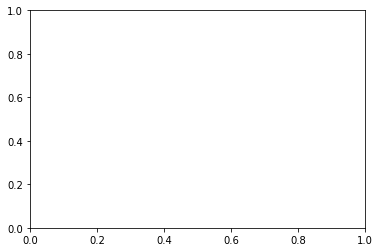

In [22]:
x = epochs_range
plt.plot(x, train_acc)
plt.plot(x, test_acc)
plt.legend(['train', 'test'], loc='upper left')
plt.title('Accuracy, learning_rate = ' + str(learning_rate), fontsize=20)
plt.xlabel('Number of epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)

### Total model

In [23]:
epochs = 100
n_chunks = 1000
learning_rate = 0.003
weight_decay = 0

In [24]:
model = build_model()

In [25]:
fit_model(model, train, train_labels, epochs = epochs, n_chunks = n_chunks, learning_rate = learning_rate, weight_decay = weight_decay)

Fitting model with epochs = 100, learning rate = 0.003
Epoch: 1/100  Loss: 1.0080
Epoch: 1/100  Loss: 0.7703
Epoch: 1/100  Loss: 0.7212
Epoch: 1/100  Loss: 0.6454
Epoch: 1/100  Loss: 0.6657
Epoch: 1/100  Loss: 0.6524
Epoch: 1/100  Loss: 0.6223
Epoch: 1/100  Loss: 0.6299
Epoch: 1/100  Loss: 0.5653
Epoch: 1/100  Loss: 0.5683
Epoch: 2/100  Loss: 0.4849
Epoch: 2/100  Loss: 0.5065
Epoch: 2/100  Loss: 0.4869
Epoch: 2/100  Loss: 0.4843
Epoch: 2/100  Loss: 0.5363
Epoch: 2/100  Loss: 0.4564
Epoch: 2/100  Loss: 0.5016
Epoch: 2/100  Loss: 0.4969
Epoch: 2/100  Loss: 0.4650
Epoch: 2/100  Loss: 0.5128
Epoch: 3/100  Loss: 0.4031
Epoch: 3/100  Loss: 0.3917
Epoch: 3/100  Loss: 0.4159
Epoch: 3/100  Loss: 0.4025
Epoch: 3/100  Loss: 0.4463
Epoch: 3/100  Loss: 0.4465
Epoch: 3/100  Loss: 0.4483
Epoch: 3/100  Loss: 0.4246
Epoch: 3/100  Loss: 0.4129
Epoch: 3/100  Loss: 0.4467
Epoch: 4/100  Loss: 0.3505
Epoch: 4/100  Loss: 0.3404
Epoch: 4/100  Loss: 0.3779
Epoch: 4/100  Loss: 0.3786
Epoch: 4/100  Loss: 0.3794


Epoch: 30/100  Loss: 0.0539
Epoch: 30/100  Loss: 0.0541
Epoch: 30/100  Loss: 0.0721
Epoch: 30/100  Loss: 0.0620
Epoch: 30/100  Loss: 0.0460
Epoch: 30/100  Loss: 0.0642
Epoch: 31/100  Loss: 0.0368
Epoch: 31/100  Loss: 0.0325
Epoch: 31/100  Loss: 0.0494
Epoch: 31/100  Loss: 0.0501
Epoch: 31/100  Loss: 0.0376
Epoch: 31/100  Loss: 0.0306
Epoch: 31/100  Loss: 0.0572
Epoch: 31/100  Loss: 0.0656
Epoch: 31/100  Loss: 0.0517
Epoch: 31/100  Loss: 0.0620
Epoch: 32/100  Loss: 0.0459
Epoch: 32/100  Loss: 0.0411
Epoch: 32/100  Loss: 0.0405
Epoch: 32/100  Loss: 0.0438
Epoch: 32/100  Loss: 0.0533
Epoch: 32/100  Loss: 0.0561
Epoch: 32/100  Loss: 0.0442
Epoch: 32/100  Loss: 0.0538
Epoch: 32/100  Loss: 0.0439
Epoch: 32/100  Loss: 0.0438
Epoch: 33/100  Loss: 0.0348
Epoch: 33/100  Loss: 0.0367
Epoch: 33/100  Loss: 0.0325
Epoch: 33/100  Loss: 0.0382
Epoch: 33/100  Loss: 0.0346
Epoch: 33/100  Loss: 0.0615
Epoch: 33/100  Loss: 0.0681
Epoch: 33/100  Loss: 0.0612
Epoch: 33/100  Loss: 0.0610
Epoch: 33/100  Loss:

Epoch: 59/100  Loss: 0.0243
Epoch: 59/100  Loss: 0.0380
Epoch: 59/100  Loss: 0.0252
Epoch: 60/100  Loss: 0.0122
Epoch: 60/100  Loss: 0.0169
Epoch: 60/100  Loss: 0.0132
Epoch: 60/100  Loss: 0.0194
Epoch: 60/100  Loss: 0.0286
Epoch: 60/100  Loss: 0.0340
Epoch: 60/100  Loss: 0.0184
Epoch: 60/100  Loss: 0.0170
Epoch: 60/100  Loss: 0.0248
Epoch: 60/100  Loss: 0.0225
Epoch: 61/100  Loss: 0.0190
Epoch: 61/100  Loss: 0.0131
Epoch: 61/100  Loss: 0.0168
Epoch: 61/100  Loss: 0.0268
Epoch: 61/100  Loss: 0.0275
Epoch: 61/100  Loss: 0.0174
Epoch: 61/100  Loss: 0.0352
Epoch: 61/100  Loss: 0.0370
Epoch: 61/100  Loss: 0.0280
Epoch: 61/100  Loss: 0.0420
Epoch: 62/100  Loss: 0.0247
Epoch: 62/100  Loss: 0.0349
Epoch: 62/100  Loss: 0.0292
Epoch: 62/100  Loss: 0.0256
Epoch: 62/100  Loss: 0.0335
Epoch: 62/100  Loss: 0.0358
Epoch: 62/100  Loss: 0.0219
Epoch: 62/100  Loss: 0.0155
Epoch: 62/100  Loss: 0.0214
Epoch: 62/100  Loss: 0.0172
Epoch: 63/100  Loss: 0.0124
Epoch: 63/100  Loss: 0.0122
Epoch: 63/100  Loss:

Epoch: 89/100  Loss: 0.0229
Epoch: 89/100  Loss: 0.0150
Epoch: 89/100  Loss: 0.0072
Epoch: 89/100  Loss: 0.0111
Epoch: 89/100  Loss: 0.0127
Epoch: 89/100  Loss: 0.0269
Epoch: 89/100  Loss: 0.0263
Epoch: 89/100  Loss: 0.0199
Epoch: 89/100  Loss: 0.0137
Epoch: 89/100  Loss: 0.0192
Epoch: 90/100  Loss: 0.0333
Epoch: 90/100  Loss: 0.0108
Epoch: 90/100  Loss: 0.0130
Epoch: 90/100  Loss: 0.0065
Epoch: 90/100  Loss: 0.0123
Epoch: 90/100  Loss: 0.0093
Epoch: 90/100  Loss: 0.0104
Epoch: 90/100  Loss: 0.0234
Epoch: 90/100  Loss: 0.0245
Epoch: 90/100  Loss: 0.0224
Epoch: 91/100  Loss: 0.0129
Epoch: 91/100  Loss: 0.0096
Epoch: 91/100  Loss: 0.0195
Epoch: 91/100  Loss: 0.0089
Epoch: 91/100  Loss: 0.0435
Epoch: 91/100  Loss: 0.0207
Epoch: 91/100  Loss: 0.0306
Epoch: 91/100  Loss: 0.0135
Epoch: 91/100  Loss: 0.0230
Epoch: 91/100  Loss: 0.0172
Epoch: 92/100  Loss: 0.0144
Epoch: 92/100  Loss: 0.0119
Epoch: 92/100  Loss: 0.0135
Epoch: 92/100  Loss: 0.0216
Epoch: 92/100  Loss: 0.0138
Epoch: 92/100  Loss:

In [26]:
evaluate_model(model, train, train_labels, test, test_labels)

Accuracy score for train set is 0.9986190476190476
Accuracy score for test set is 0.8707777777777778


(0.9986190476190476, 0.8707777777777778)

In [27]:
filepath = '../service/model.nnet'

In [28]:
metainfo = {'input_size': input_size,
            'output_size': output_size,
            'hidden_layers': hidden_sizes,
            'dropout': dropout,
            'state_dict': model.state_dict()}

torch.save(metainfo, filepath)
print("Model saved to {}\n".format(filepath))

Model saved to ../service/model.nnet

